In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


#Important keras packages
import keras
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras import losses, optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Conv2DTranspose, Reshape

K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [35]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.astype('float32')/255., x_test.astype('float32')/255.
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)

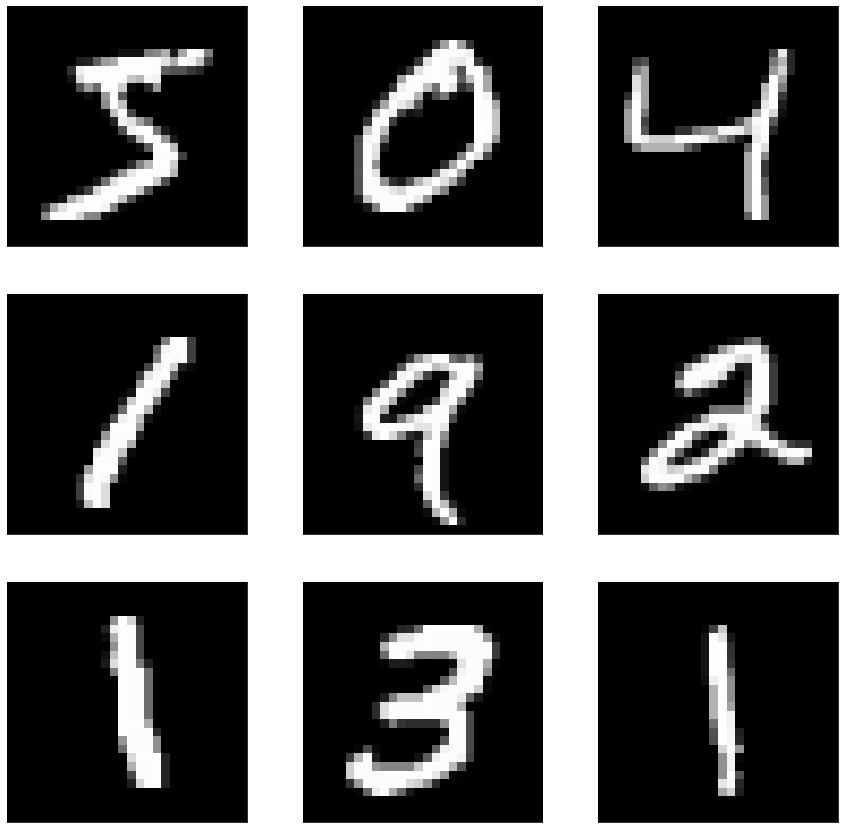

In [31]:
f, axs = plt.subplots(3,3, figsize=(15,15))
ix=0
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(x_train[ix].reshape(28,28), cmap='gray')
        axs[i,j].xaxis.set_visible(False)
        axs[i,j].yaxis.set_visible(False)
        ix+=1
plt.show()

# MLP with two hidden layers

In [32]:
#hyperparameters for the network
n_epoch = 100
n_hidden = 256
z_dim = 10
lr = 1e-4
patience=20

In [55]:
#Defining the architecture

#Encoder
x = Input(shape=(x_train.shape[1:]))
x_encoded = Dense(n_hidden, activation='relu')(x)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)
#Latent space
z = Dense(z_dim)(x_encoded)
#Decoder
x_decoded = Dense(n_hidden//2, activation='relu')(z)
x_decoded = Dense(n_hidden, activation='relu')(x_decoded)
x_hat = Dense(x_train.shape[1], activation='sigmoid')(x_decoded)

In [56]:
adam = keras.optimizers.Adam(lr=lr)
ae = Model(x, x_hat)
ae.compile(optimizer=adam, loss='mean_squared_error')
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_30 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_31 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_32 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_33 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_34 (Dense)             (None, 784)               201488    
Total para

In [61]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = patience, mode = 'min')

history = ae.fit(x_train,x_train,
          shuffle=True,
          epochs=n_epoch,
          batch_size=batch_size,
          validation_data=(x_test, x_test), 
          callbacks= [early_stopping], 
          verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 22s 370us/step - loss: 0.0650 - val_loss: 0.0398
Epoch 2/100
60000/60000 [==============================] - 20s 330us/step - loss: 0.0348 - val_loss: 0.0301
Epoch 3/100
60000/60000 [==============================] - 20s 330us/step - loss: 0.0283 - val_loss: 0.0262
Epoch 4/100
60000/60000 [==============================] - 20s 334us/step - loss: 0.0257 - val_loss: 0.0244
Epoch 5/100
60000/60000 [==============================] - 20s 332us/step - loss: 0.0243 - val_loss: 0.0233
Epoch 6/100
60000/60000 [==============================] - 20s 329us/step - loss: 0.0233 - val_loss: 0.0225
Epoch 7/100
60000/60000 [==============================] - 21s 350us/step - loss: 0.0225 - val_loss: 0.0218
Epoch 8/100
60000/60000 [==============================] - 20s 335us/step - loss: 0.0219 - val_loss: 0.0212
Epoch 9/100
60000/60000 [==============================] - 20s 332us/step - loss: 0.02

Epoch 76/100
60000/60000 [==============================] - 29s 479us/step - loss: 0.0140 - val_loss: 0.0144
Epoch 77/100
60000/60000 [==============================] - 29s 482us/step - loss: 0.0140 - val_loss: 0.0144
Epoch 78/100
60000/60000 [==============================] - 31s 512us/step - loss: 0.0140 - val_loss: 0.0143
Epoch 79/100
60000/60000 [==============================] - 28s 471us/step - loss: 0.0139 - val_loss: 0.0143
Epoch 80/100
60000/60000 [==============================] - 30s 494us/step - loss: 0.0139 - val_loss: 0.0143
Epoch 81/100
60000/60000 [==============================] - 29s 476us/step - loss: 0.0139 - val_loss: 0.0143
Epoch 82/100
60000/60000 [==============================] - 30s 493us/step - loss: 0.0138 - val_loss: 0.0142
Epoch 83/100
60000/60000 [==============================] - 30s 502us/step - loss: 0.0138 - val_loss: 0.0143
Epoch 84/100
60000/60000 [==============================] - 30s 501us/step - loss: 0.0138 - val_loss: 0.0142
Epoch 85/100
60000/

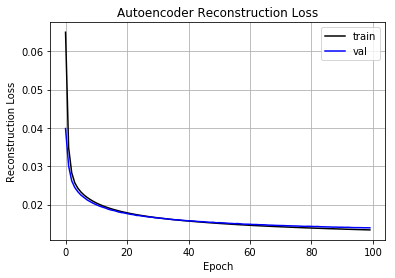

In [77]:
def plot_loss(values, values_t, metric):
    plt.plot(np.arange(len(values)), values, c='k', label='train')
    plt.plot(np.arange(len(values_t)), values_t, c='b', label='val')
    plt.title('Autoencoder {}'.format(metric))
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

val_loss = history.history['val_loss']
loss = history.history['loss']
plot_loss(loss, val_loss, 'Reconstruction Loss')

In [64]:
x_hat_test = ae.predict(x_test)

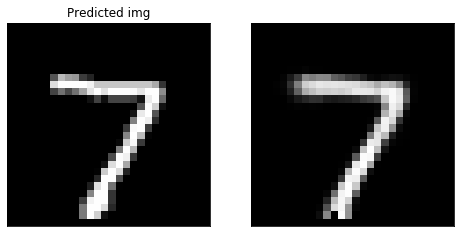

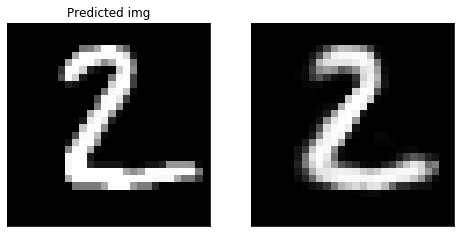

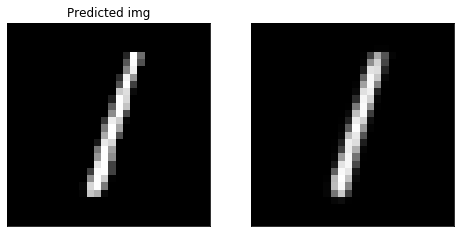

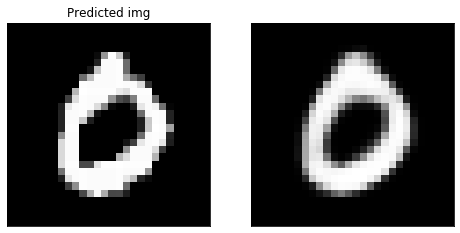

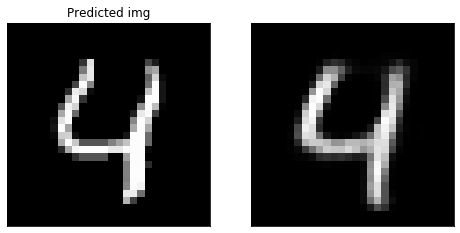

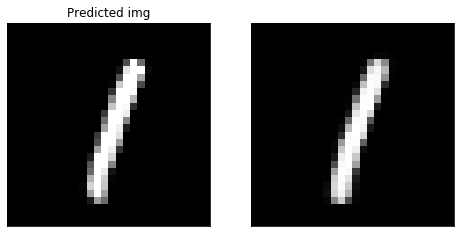

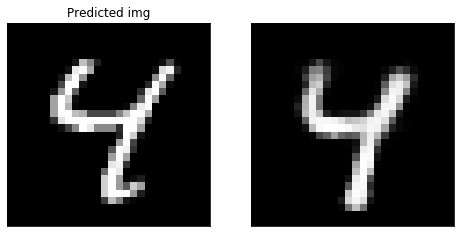

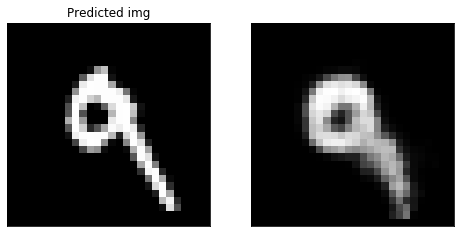

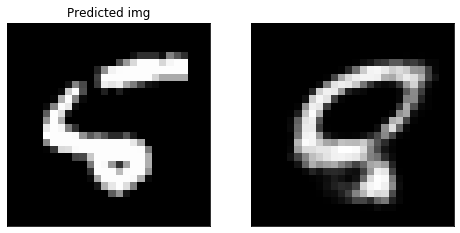

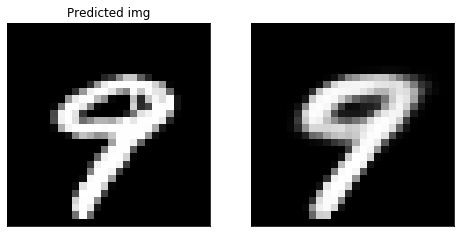

In [68]:
for i in range(10):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,8))
    ax1.set_title('Real img')
    ax1.imshow(x_test[i].reshape(28,28), cmap='gray')
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.set_title('Predicted img')
    ax2.imshow(x_hat_test[i].reshape(28,28), cmap='gray')
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    plt.show()

In [69]:
Encoder = Model(x, z)

z_test = Encoder.predict(x_test)

In [70]:
#Dimensionality Reduction using t-SNE
z_test_reduced = TSNE(n_components=2).fit_transform(z_test)

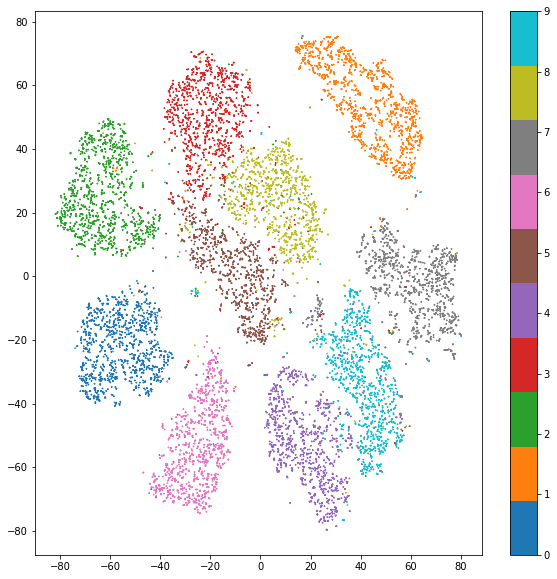

In [71]:
plt.figure(figsize=(10,10))
plt.scatter(z_test_reduced[:, 0], z_test_reduced[:, 1], c=y_test,
            s=1, cmap='tab10', marker='*')
plt.colorbar()
plt.show()

# Deep Convolutional Autoencoder (DCAE)

In [36]:
x_train = x_train.reshape(-1, 28, 28)
x_test = x_test.reshape(-1, 28, 28)

In [38]:
import cv2

target_size = (32,32) #For the following architecture, we used 32x32 images.
x_train = np.array([cv2.resize(image, dsize=target_size) for image in x_train])
x_test = np.array([cv2.resize(image, dsize=target_size) for image in x_test])
conv_dim=64
z_dim = 10
batch_size = 64

In [40]:
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

In [41]:
from keras.preprocessing.image import ImageDataGenerator
# As this DCAE uses more GPU capacity, we have to use generators.

datagen = ImageDataGenerator()
generator_train = datagen.flow(x_train, x_train, batch_size=batch_size, shuffle=True)
generator_test = datagen.flow(x_test, x_test, batch_size=batch_size, shuffle=False)

In [42]:
#Encoder
x = Input(shape=(32,32,1))
x_encoded = Conv2D(conv_dim, kernel_size=4, strides=(2,2), padding='same', activation='relu')(x)
x_encoded = Conv2D(conv_dim*2, kernel_size=4, strides=(2,2), padding='same', activation='relu')(x_encoded)
x_encoded = Conv2D(conv_dim*4, kernel_size=4, strides=(2,2), padding='same', activation='relu')(x_encoded)
x_encoded = Conv2D(conv_dim*8, kernel_size=4, strides=(1,1), padding='same', activation='relu')(x_encoded)
x_encoded = Flatten()(x_encoded)
#Latent space
z = Dense(z_dim)(x_encoded)
#Decoder
x_decoded = Dense(4 * 4 * 512)(z)
x_decoded = Reshape((4, 4, 512))(x_decoded)
x_decoded = Conv2DTranspose(conv_dim*8, kernel_size=1, strides=(1,1), padding='same', activation='relu')(x_decoded)
x_decoded = Conv2DTranspose(conv_dim*4, kernel_size=1, strides=(1,1), padding='same', activation='relu')(x_decoded)
x_decoded = Conv2DTranspose(conv_dim*2, kernel_size=4, strides=(2,2), padding='same', activation='relu')(x_decoded)
x_decoded = Conv2DTranspose(conv_dim*1, kernel_size=4, strides=(2,2), padding='same', activation='relu')(x_decoded)
x_hat = Conv2DTranspose(1, kernel_size=4, strides=(2,2), padding='same', activation='sigmoid')(x_decoded)


In [43]:
lr=1e-5
patience=10
adam = keras.optimizers.Adam(lr=lr)
dcae = Model(x, x_hat)
dcae.compile(optimizer=adam, loss='mean_squared_error')
dcae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        1088      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)         524544    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 512)         2097664   
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                81930     
__________

In [44]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = patience, mode = 'min')
n_epoch=20
history = dcae.fit_generator(generator_train,
          shuffle=True,
          epochs=n_epoch,
          validation_data=generator_test, 
          callbacks= [early_stopping],
          steps_per_epoch=x_train.shape[0]//batch_size,
          validation_steps=x_test.shape[0]//batch_size,
          verbose=1)

Epoch 1/20
937/937 [==============================] - 11s 11ms/step - loss: 0.1026 - val_loss: 0.0569
Epoch 2/20
937/937 [==============================] - 10s 10ms/step - loss: 0.0513 - val_loss: 0.0482
Epoch 3/20
937/937 [==============================] - 10s 10ms/step - loss: 0.0419 - val_loss: 0.0366
Epoch 4/20
937/937 [==============================] - 9s 10ms/step - loss: 0.0318 - val_loss: 0.0265
Epoch 5/20
937/937 [==============================] - 9s 10ms/step - loss: 0.0247 - val_loss: 0.0223
Epoch 6/20
937/937 [==============================] - 9s 10ms/step - loss: 0.0214 - val_loss: 0.0199
Epoch 7/20
937/937 [==============================] - 9s 10ms/step - loss: 0.0194 - val_loss: 0.0183
Epoch 8/20
937/937 [==============================] - 9s 10ms/step - loss: 0.0181 - val_loss: 0.0173
Epoch 9/20
937/937 [==============================] - 10s 10ms/step - loss: 0.0171 - val_loss: 0.0164
Epoch 10/20
937/937 [==============================] - 10s 10ms/step - loss: 0.0164 - v

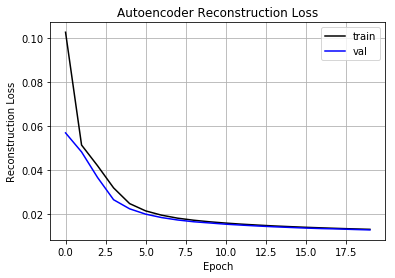

In [45]:
def plot_loss(values, values_t, metric):
    plt.plot(np.arange(len(values)), values, c='k', label='train')
    plt.plot(np.arange(len(values_t)), values_t, c='b', label='val')
    plt.title('Autoencoder {}'.format(metric))
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

val_loss = history.history['val_loss']
loss = history.history['loss']
plot_loss(loss, val_loss, 'Reconstruction Loss')

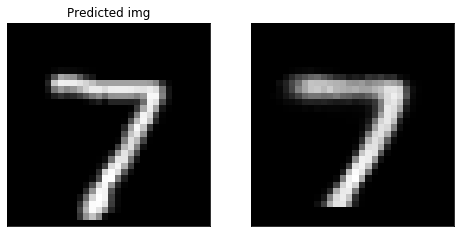

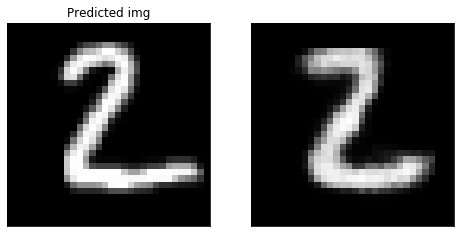

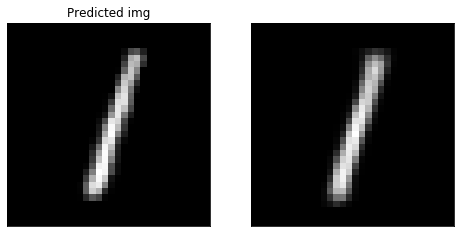

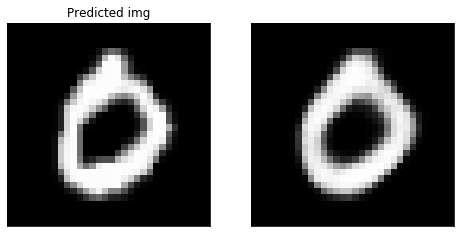

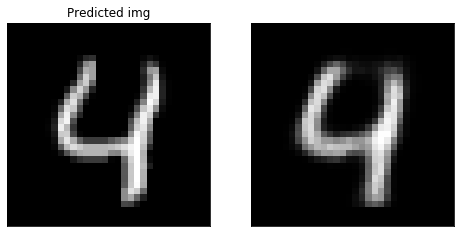

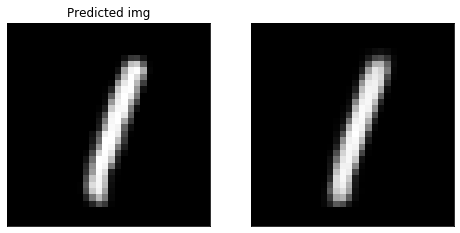

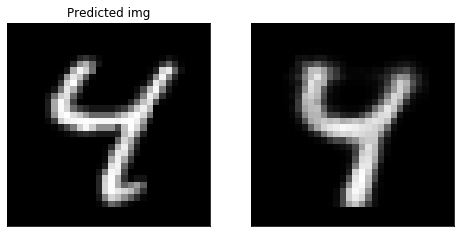

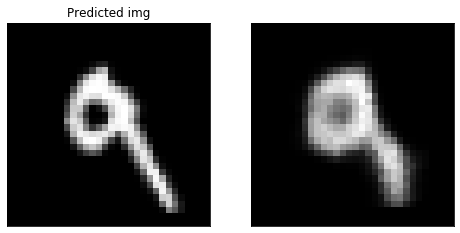

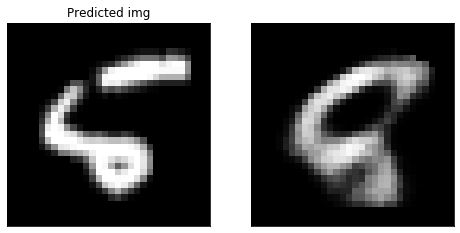

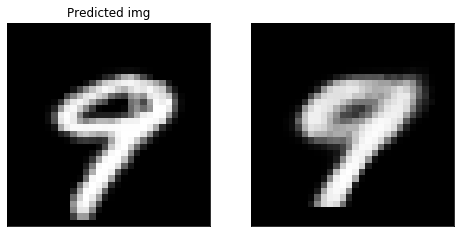

In [46]:
x_hat_test = dcae.predict(x_test)

for i in range(10):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,8))
    ax1.set_title('Real img')
    ax1.imshow(x_test[i, :, :, 0], cmap='gray')
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
    ax1.set_title('Predicted img')
    ax2.imshow(x_hat_test[i, :, :, 0], cmap='gray')
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    plt.show()

In [49]:
Encoder = Model(x, z)

z_test = Encoder.predict(x_test)
z_test_reduced = TSNE(n_components=2).fit_transform(z_test)

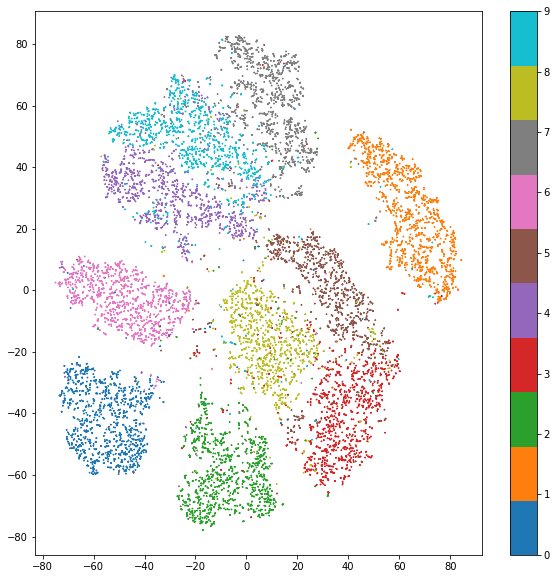

In [50]:
plt.figure(figsize=(10,10))
plt.scatter(z_test_reduced[:, 0], z_test_reduced[:, 1], c=y_test,
            s=1, cmap='tab10', marker='*')
plt.colorbar()
plt.show()